In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

# 自定义模块
from TransformerModel import TimeSeriesTransformer
from LSTMModel import TimeSeriesLSTM
from Blender import MLPBlender
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves, grid_search, safe_inverse_transform, split_time_series

# 其他库
from torch.utils.data import random_split, TensorDataset
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# 准备数据
df_complete = pd.read_csv ('../TockFormerData\SPY_2020-01-01_2025-05-03_60m.csv')

# 先把数据分成3份再create sequence，这样scale才不会泄漏
df_train, df_val, df_test = split_time_series(df_complete, 0.9, 0.05, 0.05)

In [5]:
target_cols = ['open', 'high', 'low', 'close']
seq_length = 32

# 创建序列
X_train, y_train, scaler, target_indices = create_sequences(df_train, seq_length=seq_length, target_cols=target_cols, scale=True)
X_val, y_val, _, _ = create_sequences(df_val, seq_length=seq_length, target_cols=target_cols, scaler=scaler)
X_test, y_test, _, _ = create_sequences(df_test, seq_length=seq_length, target_cols=target_cols, scaler=scaler)

数据被缩放
数据被缩放
数据被缩放


In [6]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [7]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")
print (f"Val dataset size: {len(val_dataset)}")

Train dataset size: 19187
Test dataset size: 1037
Val dataset size: 1035


In [ ]:
# 定义网格搜索 时序Transformer，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    sample_dataset(train_dataset, 0.1),
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

In [ ]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_tock = {
 'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1
 }


best_params_tock

In [ ]:
# 如果表现优异，对 tock 进行 train
tock = TimeSeriesTransformer (**best_params_tock)
train_loss, mse_list_train, r2_list_train = tock.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

In [ ]:
# 对test 进行测试
mse_list_tock, r2_list_tock, preds_tock, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)


print ("测试集 MSE: ", mse_list_tock)
print ("测试集 R²: ", r2_list_tock)

curve_dict = {}
curve_dict['predicts'] = preds_tock[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 网格搜索 LSTM 超参数

init_args_lstm = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

param_grid_lstm = {
    'hidden_dim': [64, 128],
    'num_layers': [2, 3],
}

best_params_lstm, best_score_lstm = grid_search (
    TimeSeriesLSTM,
    init_args_lstm,
    sample_dataset(train_dataset, 0.1),
    param_grid=param_grid_lstm,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params_lstm)
print ('Best avg CV MSE:', best_score_lstm)

In [8]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_lstm = {
 'hidden_dim': 64,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1
 }

best_params_lstm

{'hidden_dim': 64,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 3,
 'dropout': 0.1}

Using device: cuda
Epoch 1: reshuffling after 268 bad batches
Epoch 1: reshuffling after 366 bad batches
Epoch 1: reshuffling after 416 bad batches
Epoch 1: reshuffling after 565 bad batches
Epoch 1/100, Loss: 0.036156
Epoch 1/100, Val MSEs: [833.740478515625, 757.8658447265625, 798.6624145507812, 1139.699462890625], R²: [-7.029399871826172, -6.4778361320495605, -6.4601521492004395, -9.928592681884766]
Epoch 2: reshuffling after 87 bad batches
Epoch 2: reshuffling after 137 bad batches
Epoch 2: reshuffling after 187 bad batches
Epoch 2: reshuffling after 254 bad batches
Epoch 2: reshuffling after 375 bad batches
Epoch 2: reshuffling after 425 bad batches
Epoch 2: reshuffling after 475 bad batches
Epoch 2: reshuffling after 525 bad batches
Epoch 2: reshuffling after 575 bad batches
Epoch 2/100, Loss: 0.000336
Epoch 2/100, Val MSEs: [531.817626953125, 579.7764892578125, 588.3452758789062, 651.5921020507812], R²: [-4.12170934677124, -4.720634937286377, -4.495620250701904, -5.2481245994567

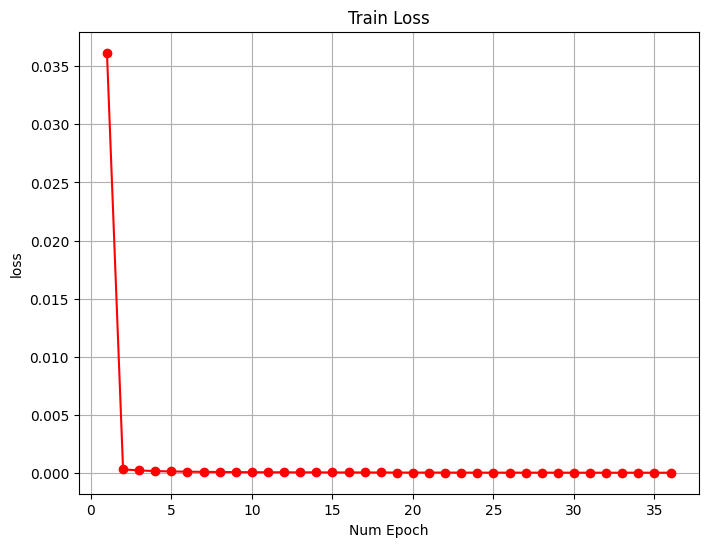

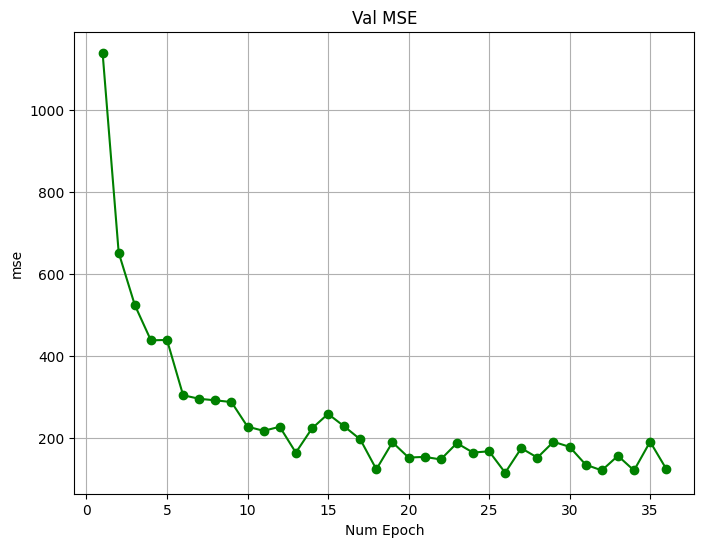

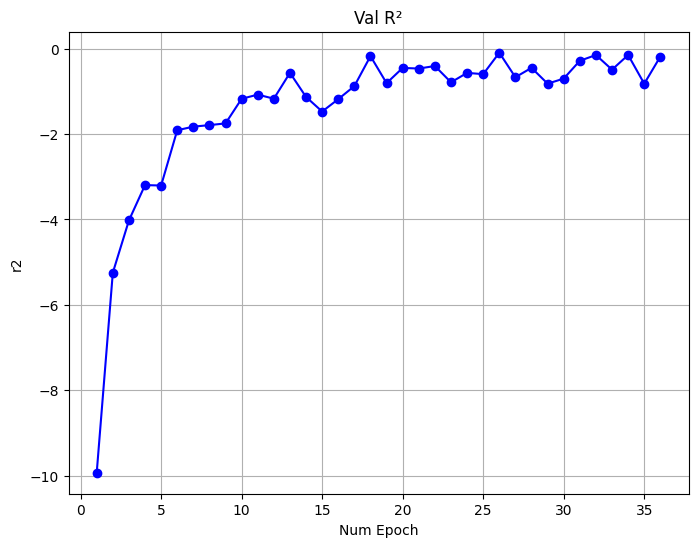

In [9]:
# 如果表现优异，对 lstm 进行 train
lstm = TimeSeriesLSTM (**best_params_lstm)
train_loss, mse_list_train, r2_list_train = lstm.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [108.79533386230469, 110.98967742919922, 96.60108184814453, 110.24169921875]
测试集 R²:  [0.8800334930419922, 0.8725709319114685, 0.8976004123687744, 0.878312349319458]


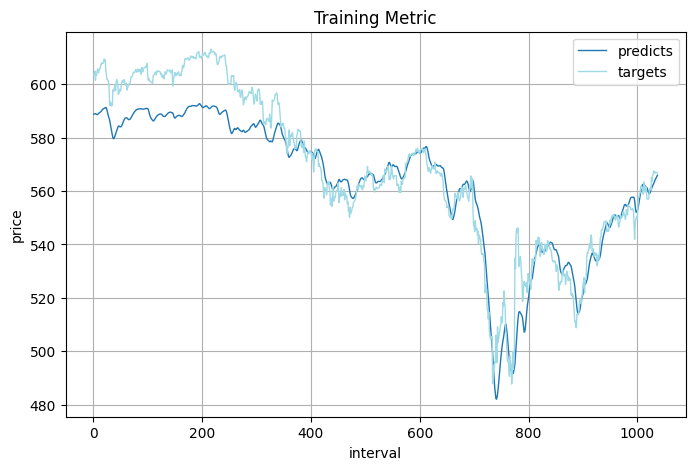

In [10]:
mse_list_lstm, r2_list_lstm, preds_lstm, targets = lstm.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_lstm)
print ("测试集 R²: ", r2_list_lstm)

curve_dict = {}
curve_dict['predicts'] = preds_lstm[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 准备数据集
X_train = train_dataset.tensors[0]
y_train = train_dataset.tensors[1]
X_val = val_dataset.tensors[0]
y_val = val_dataset.tensors[1]
X_test = test_dataset.tensors[0]
y_test = test_dataset.tensors[1]


In [ ]:
X_train_rg = X_train.reshape(X_train.shape[0], -1)

X_val_rg = X_val.reshape(X_val.shape[0], -1)

X_test_rg = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# 训练 线形模型
ridge = Ridge (alpha=1.0)
ridge.fit (X_train.reshape(X_train.shape[0], -1), y_train)
score_val = ridge.score (X_val.reshape(X_val.shape[0], -1), y_val)
score_test = ridge.score (X_test.reshape(X_test.shape[0], -1), y_test)
print (f"验证集 R²: {score_val:.4f}, 测试集R²:{score_test:.4f}")


验证集 R²: 0.9899, 测试集R²:0.9954


测试集 MSE:  [1.43232456414581, 4.653006969620246, 3.8002827686595575, 6.692748979201162]


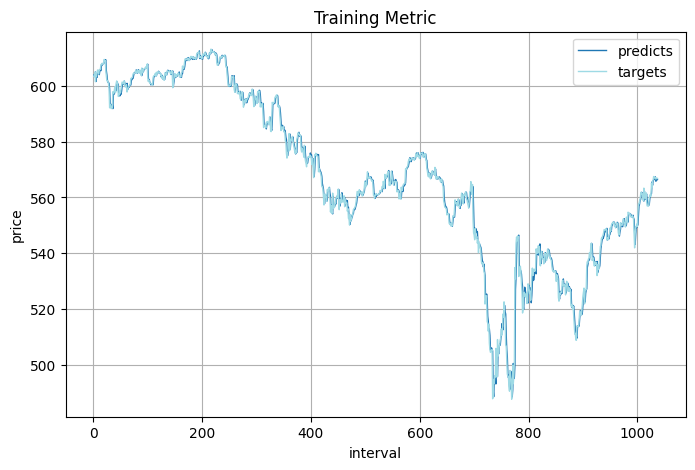

In [17]:
preds_rg = ridge.predict (X_test.reshape(X_test.shape[0], -1))
preds_rg = safe_inverse_transform (preds_rg, scaler, target_indices)

print ("测试集 MSE: ", [mean_squared_error(targets[:, i], preds_rg[:, i]) for i in range(preds_rg.shape[1])])

curve_dict = {}
curve_dict['predicts'] = preds_rg[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
print (preds_rg[:3])
print (targets[:3])

In [ ]:
# 整理数据
X_val_tock = tock.predict_model (X_val, scaler=scaler, target_indices=target_indices)
X_val_lstm = lstm.predict_model (X_val, scaler=scaler, target_indices=target_indices)

X_val_bd = np.concatenate ((X_val_tock, X_val_lstm), axis=1)
X_val_bd[:3]

In [ ]:
# 先用一个简单的线性模型进行 blender
ridge = Ridge (alpha=0.5)
ridge.fit (X_val_bd, y_val)

In [ ]:
# 预测测试集
X_test_tock = tock.predict_model (X_test, scaler=scaler, target_indices=target_indices)
X_test_lstm = lstm.predict_model (X_test, scaler=scaler, target_indices=target_indices)

X_test_bd = np.concatenate ((X_test_tock, X_test_lstm), axis=1)
X_test_bd[:3]

In [ ]:
score = ridge.score (X_test_bd, y_test)
print (f"Test R²: {score:.4f}")
print (f"feature importance:\n {ridge.coef_}")

In [ ]:
# 训练blender


blender_params = {
    'base_models': [tock, lstm],  # 基础模型列表
    'output_dim': 4,  # 4个目标值
    'hidden_dims': [16],
    'dropout': 0.1,
}

blender = MLPBlender (**blender_params)

blender.fit (val_dataset,
             val_dataset=test_dataset,
            num_epochs=100,
            batch_size=32,
            lr=1e-4,
            patience=10,
            log=True)

In [ ]:
print ("Blender weights: ", blender.get_model_importance ())

mse_list_bd, r2_list_bd, preds_bd, targets = blender.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_bd)
print ("测试集 R²: ", r2_list_bd)

curve_dict = {}
curve_dict['predicts'] = preds_bd[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 训练 residual module

from BiasCorrector import BiasCorrector
from sklearn.metrics import mean_squared_error, r2_score


x_tensor = val_dataset.tensors[0]  # 输入特征
y_tensor = val_dataset.tensors[1]  # 对应标签

y = tock.safe_inverse_transform(y_tensor.numpy(), scaler=scaler, target_indices=target_indices)

# 使用 base model 进行预测（注意需要 batch 预测，如果模型较大）
preds_val = tock.predict_model(x_tensor, scaler=scaler, bias_corrector=None, target_indices=target_indices)  # shape: (N, num_targets)


mlp_corrector = BiasCorrector(mode='mean', scale='None')
mlp_corrector.fit(preds_val, y)


In [ ]:
mse_list_cor, r2_list_cor, preds_cor, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices,
                                                                        bias_corrector=mlp_corrector)

print ("测试集 MSE: ", mse_list_cor)
print ("测试集 R²: ", r2_list_cor)

curve_dict = {}
curve_dict['predicts'] = preds_cor[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 如果test表现优异，则保存
model_out = "./xxx/xxx/"
scaler_out = "./xxx/xxx/"

os.makedirs (os.path.dirname (model_out), exist_ok=True)
os.makedirs (os.path.dirname (scaler_out), exist_ok=True)
# blender 估计也要保存

print ("=" * 10 + " 保存模型Essentials... " + "=" * 10)
torch.save (model.state_dict (), model_out)
joblib.dump (scaler, scaler_out)